<a href="https://colab.research.google.com/github/tatsuhiko-ikeda3/GAN_with_VIT/blob/main/75epoch_flower_D_vvv_G_convTattention_FID_KID_devide_in_channels_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#パッケージのダウンロード

In [ ]:
import argparse

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
import torchvision.transforms as transforms

In [ ]:
import torchvision.datasets as dset

In [ ]:
import torchvision.utils as vutils

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [ ]:
import glob

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

In [ ]:
from torch.utils.data import DataLoader
import torchvision

In [ ]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance
kid = KernelInceptionDistance(subset_size=15)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 7.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `FrechetInceptionDistance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
#ハイパーパラメータの設定

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=75)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)
parser.add_argument("--nch_d", type = int, default=64)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=32, beta1=0.5, lr_d=0.0003, lr_g=0.0002, n_epoch=75, nch_d=64, nch_g=64, z_dim=100)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform

    
    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img
    
    def __len__(self):
        return len(self.file_list)

In [ ]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([
    
    transforms.Resize(80),
    transforms.CenterCrop(60),
    transforms.ToTensor(), 
                               transforms.Normalize((0.5,),(0.5,))])

In [ ]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "train", download = True,transform = transform)

In [ ]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

In [ ]:
#モデルの設定

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x   

In [ ]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),
        
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        
    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
        self.fx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
     

    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [ ]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
     

    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [ ]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels) 
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
      
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [ ]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
      
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x 
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [ ]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = SelfAttention(in_channels)
      
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [ ]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = SelfAttention(in_channels)
      
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [ ]:
"""
        self.convt00 = self.conv_trans_layers(z_dim, 16*ngf, 4,2,1 )# ngf = the number of channels 
        self.resnet00 = resnet(16*ngf,16*ngf)
        self.res_net00 = res_net(16*ngf)
        self.sa00 = sa(16*ngf)"""

'\n        self.convt00 = self.conv_trans_layers(z_dim, 16*ngf, 4,2,1 )# ngf = the number of channels \n        self.resnet00 = resnet(16*ngf,16*ngf)\n        self.res_net00 = res_net(16*ngf)\n        self.sa00 = sa(16*ngf)'

In [ ]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()

        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0, attention=False )# ngf = the number of channels 
        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1  )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )
        

    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=True, res_net= False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_1(out_channels))


        net = nn.Sequential(*layers)#listのアンパック

        return net
    
    def forward(self, x):      
        out = self.convt1(x)

        out = self.convt2(out)       

        out = self.convt3(out)
      
        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [ ]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)

        
    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if attention:
            layers.append(SelfAttention(out_channels))
        if res_net:
            layers.append(ResidualBlock_1(out_channels))

       
        net = nn.Sequential(*layers)#listのアンパック
       
        return net
    
    def forward(self, x):
        out = self.conv1(x)

        out = self.vit2(out)       

        out = self.vit3(out)
      
        out = self.vit4(out)

        out = self.conv5(out)

        return out

In [ ]:
#モデルのトレーニング

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
device

device(type='cuda')

In [ ]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspose2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-2)
    )
  )
  (convt3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [01:39<00:00,  1.04it/s]


epoch: 0, lossD:1.3131259752130044, lossG:5.332811478272225,lossG_fake:2.7188098118143174, lossG_real:2.614001656041562 


/usr/local/lib/python3.7/dist-packages/scipy/linalg/_matfuncs_sqrtm.py:186: RuntimeWarning: invalid value encountered in double_scalars
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


evaluate:140.05184936523438,kid_mean:0.08223997056484222, kid_std:0.01938050240278244,kid_:(tensor(0.0822), tensor(0.0194))


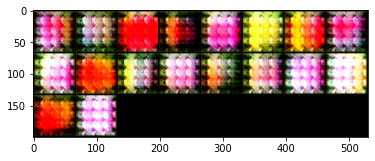

100%|██████████| 103/103 [00:56<00:00,  1.82it/s]


epoch: 1, lossD:1.545100050065124, lossG:3.2294579941092185,lossG_fake:1.7625699031700208, lossG_real:1.4668881013555435 


evaluate:138.8580322265625,kid_mean:0.08389530330896378, kid_std:0.03262840583920479,kid_:(tensor(0.0839), tensor(0.0326))


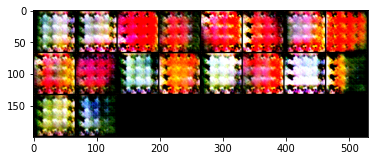

100%|██████████| 103/103 [00:58<00:00,  1.77it/s]


epoch: 2, lossD:1.5828118011789414, lossG:3.218362456386529,lossG_fake:1.766782089344506, lossG_real:1.451580367042023 


evaluate:140.0320281982422,kid_mean:0.08745978027582169, kid_std:0.041215233504772186,kid_:(tensor(0.0875), tensor(0.0412))


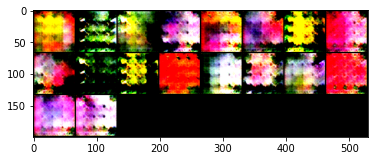

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 3, lossD:1.6307525310701536, lossG:3.023942141856962,lossG_fake:1.6414475325241829, lossG_real:1.3824946104901508 


evaluate:123.20941925048828,kid_mean:0.072649285197258, kid_std:0.038848262280225754,kid_:(tensor(0.0726), tensor(0.0388))


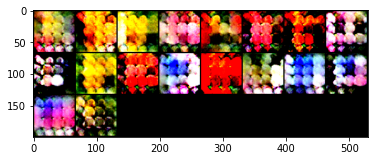

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 4, lossD:1.6215341924463662, lossG:3.05139196034774,lossG_fake:1.6413088608713984, lossG_real:1.410083086745253 


evaluate:123.84952545166016,kid_mean:0.07743506878614426, kid_std:0.036921460181474686,kid_:(tensor(0.0774), tensor(0.0369))


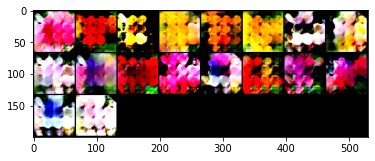

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 5, lossD:1.6334140509077646, lossG:2.9887401455814397,lossG_fake:1.605744269287702, lossG_real:1.3829958728216227 


evaluate:126.29598236083984,kid_mean:0.07161697745323181, kid_std:0.039262957870960236,kid_:(tensor(0.0716), tensor(0.0393))


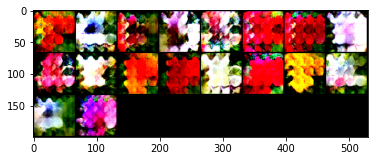

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 6, lossD:1.6605228926371602, lossG:2.930561878148792,lossG_fake:1.579294038050383, lossG_real:1.3512678424131523 


evaluate:121.60302734375,kid_mean:0.06952725350856781, kid_std:0.037287287414073944,kid_:(tensor(0.0695), tensor(0.0373))


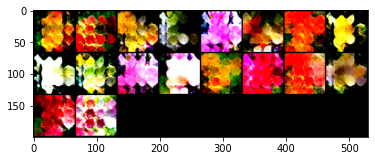

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 7, lossD:1.6281190601367395, lossG:3.0064109968907626,lossG_fake:1.6081143363008221, lossG_real:1.398296666376799 


evaluate:120.455078125,kid_mean:0.07684076577425003, kid_std:0.03795416280627251,kid_:(tensor(0.0768), tensor(0.0380))


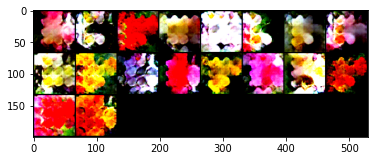

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 8, lossD:1.597130181719956, lossG:3.006365283021649,lossG_fake:1.59400731961704, lossG_real:1.4123579610898658 


evaluate:117.68704223632812,kid_mean:0.06724489480257034, kid_std:0.041347868740558624,kid_:(tensor(0.0672), tensor(0.0413))


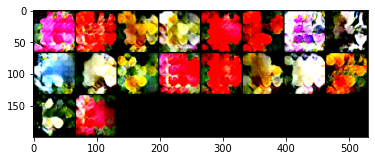

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 9, lossD:1.5847978915983034, lossG:3.069540903406236,lossG_fake:1.6270624410758898, lossG_real:1.4424784588582307 


evaluate:122.40323638916016,kid_mean:0.07672306150197983, kid_std:0.03785770386457443,kid_:(tensor(0.0767), tensor(0.0379))


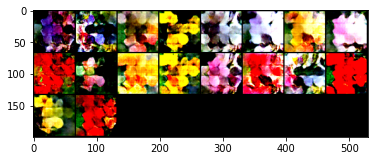

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 10, lossD:1.5757277243345686, lossG:3.0726598281304813,lossG_fake:1.6148296698783209, lossG_real:1.457830152465302 


evaluate:124.69989013671875,kid_mean:0.07213305681943893, kid_std:0.03813251107931137,kid_:(tensor(0.0721), tensor(0.0381))


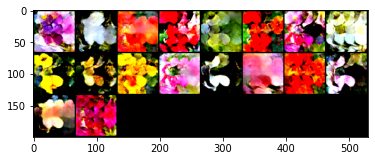

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 11, lossD:1.5620293443642774, lossG:3.058239969235022,lossG_fake:1.6051610974432196, lossG_real:1.4530788845228917 


evaluate:124.6468505859375,kid_mean:0.06960310786962509, kid_std:0.03664781525731087,kid_:(tensor(0.0696), tensor(0.0366))


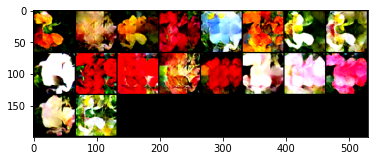

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 12, lossD:1.533961120161038, lossG:3.124415446253656,lossG_fake:1.6249512804364694, lossG_real:1.4994641808630194 


evaluate:122.25829315185547,kid_mean:0.07750704884529114, kid_std:0.037718988955020905,kid_:(tensor(0.0775), tensor(0.0377))


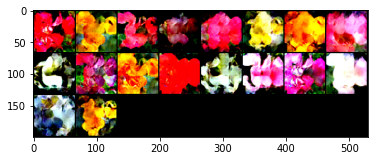

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 13, lossD:1.5596926964602424, lossG:3.0873160153916737,lossG_fake:1.5975690993290503, lossG_real:1.4897469241642258 


evaluate:118.84040832519531,kid_mean:0.07054992765188217, kid_std:0.035683535039424896,kid_:(tensor(0.0705), tensor(0.0357))


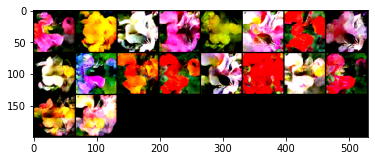

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 14, lossD:1.5309626292256475, lossG:3.133408486264423,lossG_fake:1.6263433741134348, lossG_real:1.50706513298368 


evaluate:115.90838623046875,kid_mean:0.06761784851551056, kid_std:0.038422927260398865,kid_:(tensor(0.0676), tensor(0.0384))


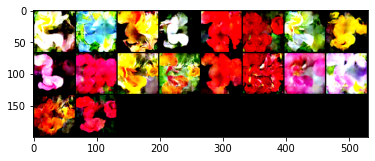

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 15, lossD:1.533749043362812, lossG:3.1849097673175404,lossG_fake:1.6558122958951784, lossG_real:1.5290974777879067 


evaluate:115.01180267333984,kid_mean:0.06607774645090103, kid_std:0.03702152520418167,kid_:(tensor(0.0661), tensor(0.0370))


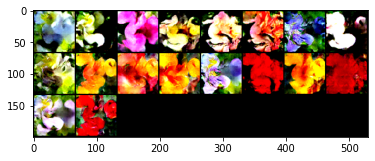

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 16, lossD:1.508505376797278, lossG:3.22649940009256,lossG_fake:1.6643310576966666, lossG_real:1.5621683412385219 


evaluate:116.98941040039062,kid_mean:0.06479756534099579, kid_std:0.039977215230464935,kid_:(tensor(0.0648), tensor(0.0400))


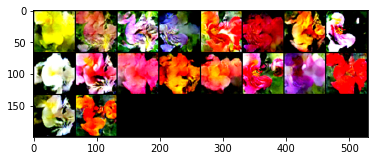

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 17, lossD:1.5080778263147594, lossG:3.243238930563325,lossG_fake:1.6741705693087532, lossG_real:1.5690683705135458 


evaluate:116.7666015625,kid_mean:0.07035809755325317, kid_std:0.034848932176828384,kid_:(tensor(0.0704), tensor(0.0348))


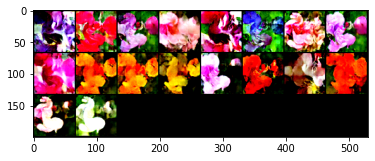

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 18, lossD:1.4926327316506396, lossG:3.2929563568633737,lossG_fake:1.6931001231508347, lossG_real:1.5998562481796856 


evaluate:116.45933532714844,kid_mean:0.07139676809310913, kid_std:0.03864667937159538,kid_:(tensor(0.0714), tensor(0.0386))


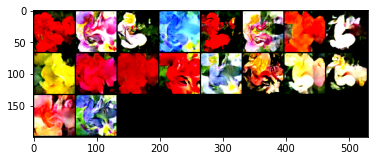

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 19, lossD:1.4738316721129185, lossG:3.316475155284104,lossG_fake:1.7054063070167615, lossG_real:1.6110688500033998 


evaluate:114.43038940429688,kid_mean:0.07346814125776291, kid_std:0.03826046735048294,kid_:(tensor(0.0735), tensor(0.0383))


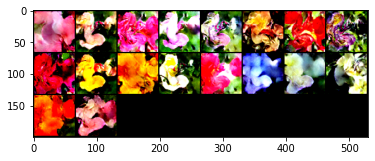

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 20, lossD:1.4634850812189788, lossG:3.358997724588635,lossG_fake:1.7343922517832042, lossG_real:1.6246054780136034 


evaluate:116.41636657714844,kid_mean:0.0679062232375145, kid_std:0.03860776871442795,kid_:(tensor(0.0679), tensor(0.0386))


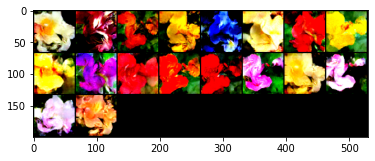

100%|██████████| 103/103 [00:59<00:00,  1.74it/s]


epoch: 21, lossD:1.4377353411276363, lossG:3.394087805331332,lossG_fake:1.737819357983117, lossG_real:1.6562684276728954 


evaluate:114.37300109863281,kid_mean:0.05743818357586861, kid_std:0.033481333404779434,kid_:(tensor(0.0574), tensor(0.0335))


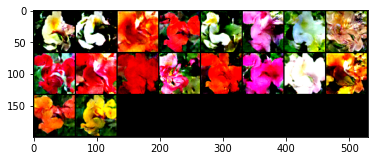

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 22, lossD:1.4293356902391008, lossG:3.404760853758136,lossG_fake:1.7497602782203157, lossG_real:1.655000581903365 


evaluate:107.65608215332031,kid_mean:0.06437530368566513, kid_std:0.03656477481126785,kid_:(tensor(0.0644), tensor(0.0366))


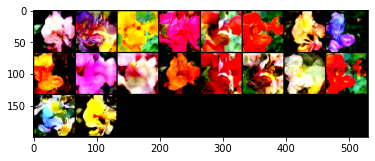

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 23, lossD:1.4267080524592723, lossG:3.4544779536793535,lossG_fake:1.7678593536025111, lossG_real:1.6866185827162659 


evaluate:107.46382141113281,kid_mean:0.05952070280909538, kid_std:0.03563709184527397,kid_:(tensor(0.0595), tensor(0.0356))


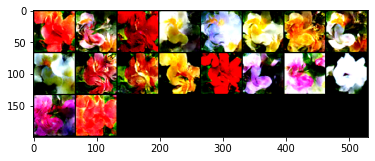

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 24, lossD:1.374872079173338, lossG:3.546214020367965,lossG_fake:1.8101704311602325, lossG_real:1.7360436025175077 


evaluate:106.89924621582031,kid_mean:0.06046051159501076, kid_std:0.03544054925441742,kid_:(tensor(0.0605), tensor(0.0354))


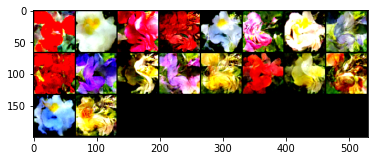

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 25, lossD:1.4002438552171281, lossG:3.513398969057694,lossG_fake:1.7842870001654023, lossG_real:1.7291119561612027 


evaluate:106.43824005126953,kid_mean:0.059931155294179916, kid_std:0.03957995027303696,kid_:(tensor(0.0599), tensor(0.0396))


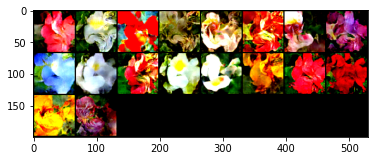

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 26, lossD:1.371004108086373, lossG:3.606755765896399,lossG_fake:1.8375312680179634, lossG_real:1.7692244990358075 


evaluate:107.66456604003906,kid_mean:0.06397596001625061, kid_std:0.040883418172597885,kid_:(tensor(0.0640), tensor(0.0409))


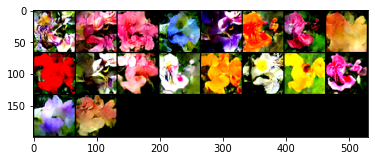

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 27, lossD:1.3533776720750679, lossG:3.641190308968998,lossG_fake:1.8382885762788717, lossG_real:1.8029017263245815 


evaluate:106.65924072265625,kid_mean:0.06517156958580017, kid_std:0.03838677704334259,kid_:(tensor(0.0652), tensor(0.0384))


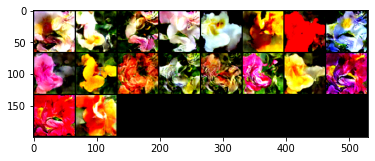

100%|██████████| 103/103 [00:59<00:00,  1.72it/s]


epoch: 28, lossD:1.3270601722800617, lossG:3.709742789129609,lossG_fake:1.8782217942395256, lossG_real:1.8315209937327117 


evaluate:108.93533325195312,kid_mean:0.06600138545036316, kid_std:0.03856692835688591,kid_:(tensor(0.0660), tensor(0.0386))


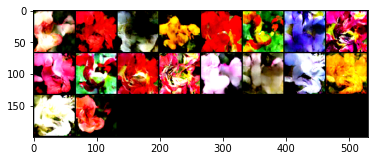

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 29, lossD:1.3027159160780675, lossG:3.7580785334688946,lossG_fake:1.8963413990817024, lossG_real:1.8617371436461663 


evaluate:107.98090362548828,kid_mean:0.07057437300682068, kid_std:0.03677903488278389,kid_:(tensor(0.0706), tensor(0.0368))


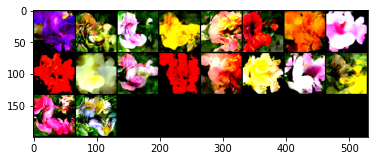

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 30, lossD:1.304213519813945, lossG:3.8102839270841726,lossG_fake:1.9275670815440058, lossG_real:1.8827168478549106 


evaluate:107.4215316772461,kid_mean:0.06305515021085739, kid_std:0.03482814505696297,kid_:(tensor(0.0631), tensor(0.0348))


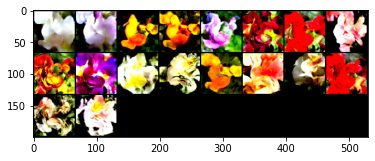

100%|██████████| 103/103 [00:59<00:00,  1.74it/s]


epoch: 31, lossD:1.2752188883938835, lossG:3.8151660243284353,lossG_fake:1.929578392251024, lossG_real:1.8855876367068984 


evaluate:107.54436492919922,kid_mean:0.06922988593578339, kid_std:0.04112076386809349,kid_:(tensor(0.0692), tensor(0.0411))


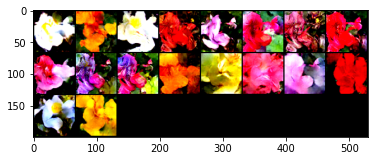

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 32, lossD:1.251832231734563, lossG:3.889081165628526,lossG_fake:1.957361597459293, lossG_real:1.931719567011861 


evaluate:106.89264678955078,kid_mean:0.05665777996182442, kid_std:0.03689449280500412,kid_:(tensor(0.0567), tensor(0.0369))


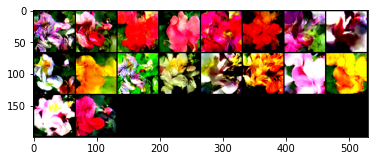

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 33, lossD:1.2419620422483648, lossG:3.9162680662951423,lossG_fake:1.9761477998159465, lossG_real:1.9401202653218241 


evaluate:105.76832580566406,kid_mean:0.06852886825799942, kid_std:0.03663604333996773,kid_:(tensor(0.0685), tensor(0.0366))


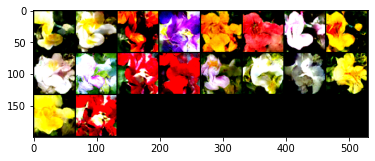

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 34, lossD:1.2452474884616518, lossG:3.957343349179018,lossG_fake:1.986004397707078, lossG_real:1.971338973462003 


evaluate:103.97098541259766,kid_mean:0.05602879822254181, kid_std:0.03345457836985588,kid_:(tensor(0.0560), tensor(0.0335))


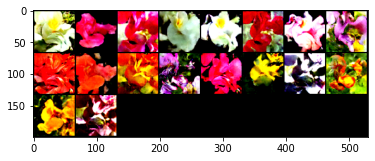

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 35, lossD:1.1994147549555139, lossG:4.037587918124153,lossG_fake:2.032019465872385, lossG_real:2.0055684615107414 


evaluate:104.77111053466797,kid_mean:0.0610540397465229, kid_std:0.03733835369348526,kid_:(tensor(0.0611), tensor(0.0373))


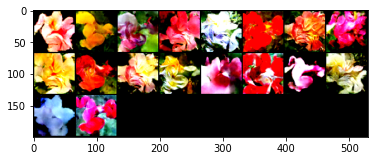

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 36, lossD:1.1881127658399564, lossG:4.043939419163084,lossG_fake:2.0223721775036414, lossG_real:2.021567230085725 


evaluate:104.49862670898438,kid_mean:0.06146232783794403, kid_std:0.03741482272744179,kid_:(tensor(0.0615), tensor(0.0374))


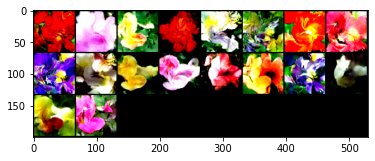

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 37, lossD:1.1640729765290196, lossG:4.163231352000561,lossG_fake:2.0733263376847053, lossG_real:2.0899050247322006 


evaluate:106.2356948852539,kid_mean:0.06314163655042648, kid_std:0.0339873768389225,kid_:(tensor(0.0631), tensor(0.0340))


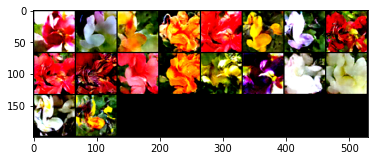

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 38, lossD:1.158591140821142, lossG:4.180617598653997,lossG_fake:2.089250403700523, lossG_real:2.0913672007403328 


evaluate:106.3269271850586,kid_mean:0.06117192283272743, kid_std:0.036925118416547775,kid_:(tensor(0.0612), tensor(0.0369))


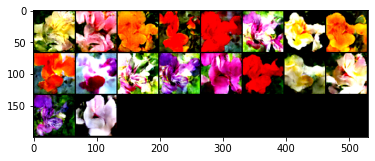

100%|██████████| 103/103 [00:59<00:00,  1.74it/s]


epoch: 39, lossD:1.1306017075927512, lossG:4.256799658525337,lossG_fake:2.1286191106999963, lossG_real:2.128180525835278 


evaluate:105.23446655273438,kid_mean:0.06123775616288185, kid_std:0.03672078624367714,kid_:(tensor(0.0612), tensor(0.0367))


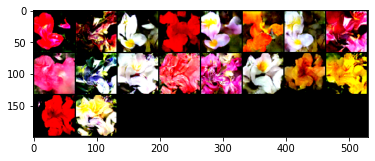

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 40, lossD:1.1145740105110464, lossG:4.334729590462249,lossG_fake:2.158315861109391, lossG_real:2.1764137351397173 


evaluate:106.22142028808594,kid_mean:0.05962143838405609, kid_std:0.0340842641890049,kid_:(tensor(0.0596), tensor(0.0341))


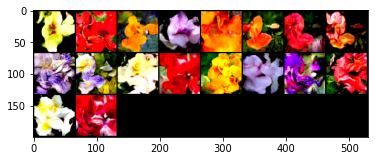

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 41, lossD:1.1199532295893697, lossG:4.317828078871792,lossG_fake:2.14660080196788, lossG_real:2.1712272607007073 


evaluate:106.66099548339844,kid_mean:0.06854952871799469, kid_std:0.03277438506484032,kid_:(tensor(0.0685), tensor(0.0328))


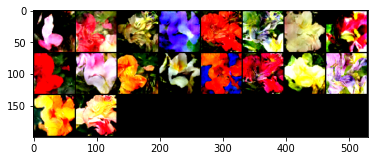

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 42, lossD:1.0926522751456325, lossG:4.398390607926452,lossG_fake:2.1689493679305882, lossG_real:2.229441243467979 


evaluate:106.51895904541016,kid_mean:0.05796736106276512, kid_std:0.03272049501538277,kid_:(tensor(0.0580), tensor(0.0327))


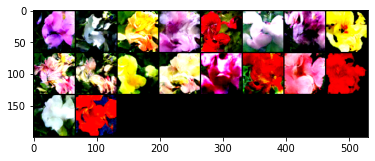

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 43, lossD:1.0697908945453978, lossG:4.443849644614655,lossG_fake:2.202128303861155, lossG_real:2.2417213488551018 


evaluate:107.01215362548828,kid_mean:0.0708136186003685, kid_std:0.039912521839141846,kid_:(tensor(0.0708), tensor(0.0399))


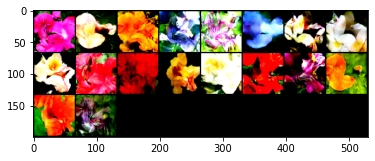

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 44, lossD:1.0649149730367569, lossG:4.446976830658404,lossG_fake:2.1897661361879517, lossG_real:2.2572107222473736 


evaluate:105.8770523071289,kid_mean:0.06418215483427048, kid_std:0.039103660732507706,kid_:(tensor(0.0642), tensor(0.0391))


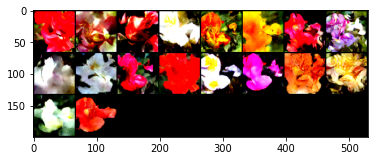

100%|██████████| 103/103 [00:59<00:00,  1.74it/s]


epoch: 45, lossD:1.0221319215968974, lossG:4.592934654754343,lossG_fake:2.2456803344985814, lossG_real:2.347254324885248 


evaluate:104.38833618164062,kid_mean:0.06460247188806534, kid_std:0.03837616369128227,kid_:(tensor(0.0646), tensor(0.0384))


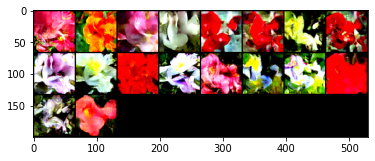

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 46, lossD:1.1705222714294508, lossG:4.478186899018519,lossG_fake:2.220291437454594, lossG_real:2.2578954569344383 


evaluate:103.9699935913086,kid_mean:0.06172863021492958, kid_std:0.0375644825398922,kid_:(tensor(0.0617), tensor(0.0376))


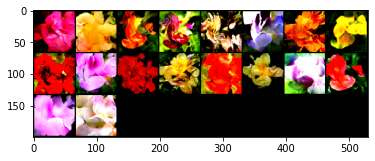

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 47, lossD:1.0080822011799488, lossG:4.595786409470642,lossG_fake:2.2631934441409065, lossG_real:2.3325929421823 


evaluate:104.34148406982422,kid_mean:0.06378218531608582, kid_std:0.033551961183547974,kid_:(tensor(0.0638), tensor(0.0336))


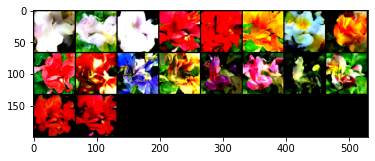

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 48, lossD:0.9849155371628918, lossG:4.691894568285896,lossG_fake:2.2924237054528542, lossG_real:2.3994708408429783 


evaluate:106.06526947021484,kid_mean:0.06448858976364136, kid_std:0.037639833986759186,kid_:(tensor(0.0645), tensor(0.0376))


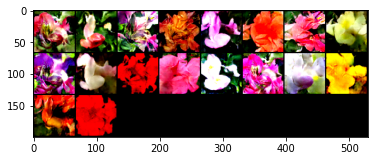

100%|██████████| 103/103 [00:59<00:00,  1.75it/s]


epoch: 49, lossD:0.9741208564887927, lossG:4.758816121851356,lossG_fake:2.3000419961596, lossG_real:2.458774126849128 


evaluate:105.16773223876953,kid_mean:0.06566619873046875, kid_std:0.03916409611701965,kid_:(tensor(0.0657), tensor(0.0392))


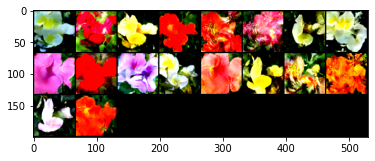

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 50, lossD:0.9543981667861198, lossG:4.840137646036241,lossG_fake:2.336957487087805, lossG_real:2.503180150846833 


evaluate:105.0074234008789,kid_mean:0.06342042237520218, kid_std:0.0382724329829216,kid_:(tensor(0.0634), tensor(0.0383))


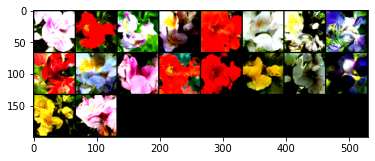

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 51, lossD:0.9442095010025987, lossG:5.015309000478207,lossG_fake:2.408197135601229, lossG_real:2.6071118602474916 


evaluate:104.98092651367188,kid_mean:0.06655918061733246, kid_std:0.03603619709610939,kid_:(tensor(0.0666), tensor(0.0360))


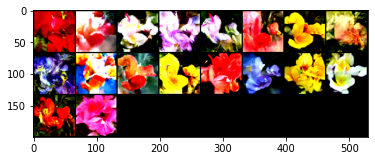

100%|██████████| 103/103 [00:59<00:00,  1.74it/s]


epoch: 52, lossD:0.9357609366907657, lossG:4.972522851332878,lossG_fake:2.4261773859412923, lossG_real:2.546345474650559 


evaluate:104.94593811035156,kid_mean:0.07119506597518921, kid_std:0.04455798119306564,kid_:(tensor(0.0712), tensor(0.0446))


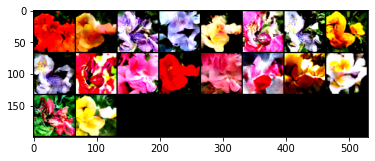

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 53, lossD:0.9737294565126734, lossG:4.995796087876107,lossG_fake:2.402803149038148, lossG_real:2.592992946939561 


evaluate:105.02940368652344,kid_mean:0.06412097811698914, kid_std:0.03884964808821678,kid_:(tensor(0.0641), tensor(0.0388))


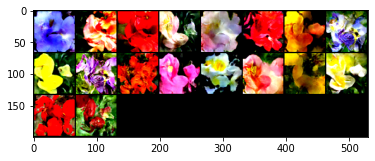

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 54, lossD:0.8971911625376026, lossG:5.056023005142952,lossG_fake:2.4295028552268314, lossG_real:2.6265201487587495 


evaluate:105.21096801757812,kid_mean:0.06228307634592056, kid_std:0.03814229741692543,kid_:(tensor(0.0623), tensor(0.0381))


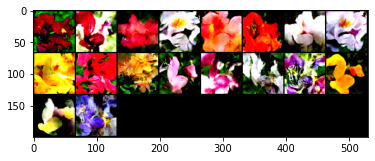

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 55, lossD:0.882972966409424, lossG:5.212254380716861,lossG_fake:2.495120744103367, lossG_real:2.717133649923269 


evaluate:105.18406677246094,kid_mean:0.06466446071863174, kid_std:0.03985734283924103,kid_:(tensor(0.0647), tensor(0.0399))


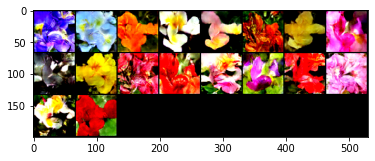

100%|██████████| 103/103 [00:59<00:00,  1.75it/s]


epoch: 56, lossD:0.8853824549508327, lossG:5.123244841121933,lossG_fake:2.4407528986051243, lossG_real:2.6824919344152063 


evaluate:103.73117065429688,kid_mean:0.06624916195869446, kid_std:0.037944987416267395,kid_:(tensor(0.0662), tensor(0.0379))


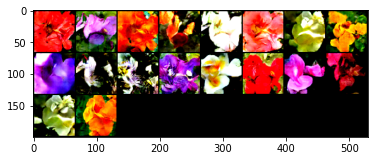

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 57, lossD:0.8541152572747573, lossG:5.286173167737942,lossG_fake:2.506737102582617, lossG_real:2.7794360605258386 


evaluate:104.24390411376953,kid_mean:0.061554860323667526, kid_std:0.04082790017127991,kid_:(tensor(0.0616), tensor(0.0408))


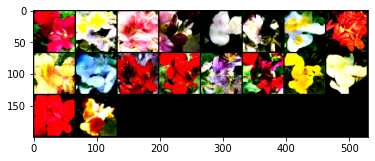

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 58, lossD:0.8774140393271029, lossG:5.485726375024296,lossG_fake:2.6003991214974413, lossG_real:2.885327251212111 


evaluate:104.74081420898438,kid_mean:0.0599173940718174, kid_std:0.03678525611758232,kid_:(tensor(0.0599), tensor(0.0368))


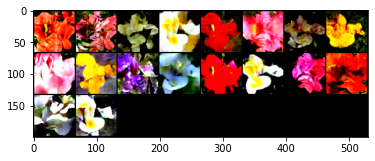

100%|██████████| 103/103 [00:59<00:00,  1.74it/s]


epoch: 59, lossD:0.8277350554188478, lossG:5.283507263776168,lossG_fake:2.519366650905424, lossG_real:2.764140636018179 


evaluate:105.93303680419922,kid_mean:0.06417030096054077, kid_std:0.041393253952264786,kid_:(tensor(0.0642), tensor(0.0414))


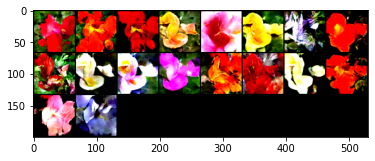

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 60, lossD:0.7830165997870917, lossG:5.5824471260737445,lossG_fake:2.6375618247152532, lossG_real:2.9448852863126587 


evaluate:105.25701904296875,kid_mean:0.060497865080833435, kid_std:0.03336679935455322,kid_:(tensor(0.0605), tensor(0.0334))


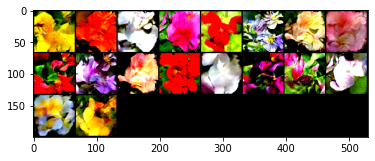

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 61, lossD:0.7912057235981654, lossG:5.6618794098641105,lossG_fake:2.648513143502393, lossG_real:3.0133662605748595 


evaluate:104.62220764160156,kid_mean:0.059554751962423325, kid_std:0.032586719840765,kid_:(tensor(0.0596), tensor(0.0326))


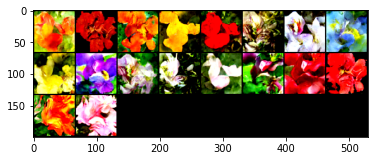

100%|██████████| 103/103 [00:59<00:00,  1.75it/s]


epoch: 62, lossD:0.7676479839584203, lossG:5.748542243994556,lossG_fake:2.676859636908596, lossG_real:3.0716826024564723 


evaluate:105.49576568603516,kid_mean:0.06044907122850418, kid_std:0.03461812809109688,kid_:(tensor(0.0604), tensor(0.0346))


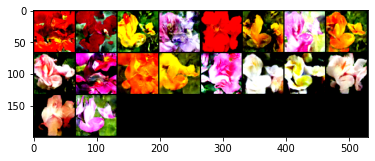

100%|██████████| 103/103 [00:59<00:00,  1.74it/s]


epoch: 63, lossD:0.7619226007785612, lossG:5.828986288274376,lossG_fake:2.716447638076486, lossG_real:3.1125386444110315 


evaluate:106.35721588134766,kid_mean:0.06597790122032166, kid_std:0.03866126760840416,kid_:(tensor(0.0660), tensor(0.0387))


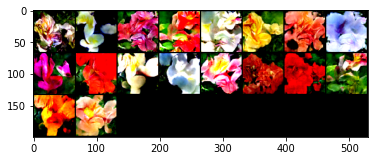

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 64, lossD:0.8069558299860908, lossG:5.7564867075207165,lossG_fake:2.6808852096205777, lossG_real:3.0756015094738562 


evaluate:105.50112915039062,kid_mean:0.059340983629226685, kid_std:0.03511304780840874,kid_:(tensor(0.0593), tensor(0.0351))


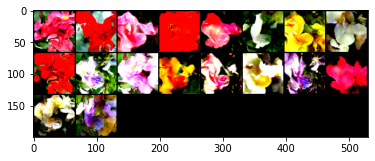

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 65, lossD:0.721170033355361, lossG:5.95585298538208,lossG_fake:2.746954579955166, lossG_real:3.2088983938531968 


evaluate:105.6500015258789,kid_mean:0.06533482670783997, kid_std:0.03980415686964989,kid_:(tensor(0.0653), tensor(0.0398))


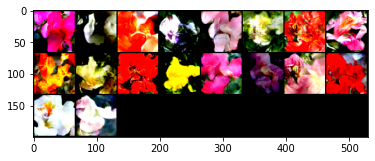

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 66, lossD:0.7030730235923841, lossG:6.117340740648288,lossG_fake:2.799636215839571, lossG_real:3.3177045236513454 


evaluate:106.41389465332031,kid_mean:0.0640939399600029, kid_std:0.03654478117823601,kid_:(tensor(0.0641), tensor(0.0365))


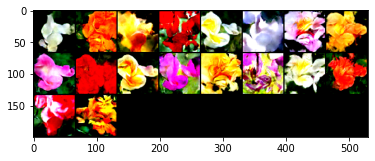

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 67, lossD:0.7410060460272344, lossG:6.131426903808001,lossG_fake:2.779185734906243, lossG_real:3.352241174688617 


evaluate:106.97955322265625,kid_mean:0.05666542425751686, kid_std:0.032515767961740494,kid_:(tensor(0.0567), tensor(0.0325))


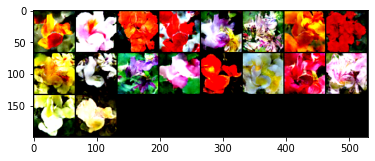

100%|██████████| 103/103 [00:59<00:00,  1.75it/s]


epoch: 68, lossD:0.7594353766406624, lossG:6.072615118860041,lossG_fake:2.7836326013490993, lossG_real:3.288982534871518 


evaluate:108.2476806640625,kid_mean:0.06427280604839325, kid_std:0.04037495702505112,kid_:(tensor(0.0643), tensor(0.0404))


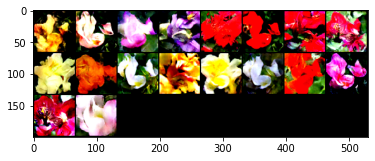

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 69, lossD:0.8047988939921833, lossG:5.973170923955232,lossG_fake:2.758481810393843, lossG_real:3.214689119348248 


evaluate:108.95008087158203,kid_mean:0.05993211641907692, kid_std:0.03652092069387436,kid_:(tensor(0.0599), tensor(0.0365))


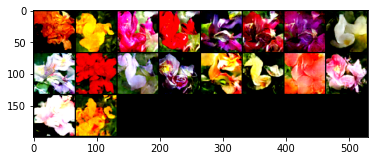

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 70, lossD:0.7045153317231576, lossG:6.16273605939254,lossG_fake:2.8329283126349587, lossG_real:3.3298077421280943 


evaluate:108.48589324951172,kid_mean:0.06854015588760376, kid_std:0.042384713888168335,kid_:(tensor(0.0685), tensor(0.0424))


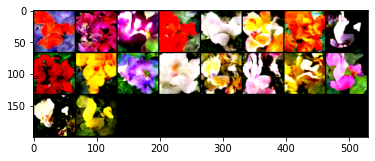

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 71, lossD:0.681546644823065, lossG:6.368906192409182,lossG_fake:2.8627515626185147, lossG_real:3.5061546228464366 


evaluate:109.24153137207031,kid_mean:0.06350722908973694, kid_std:0.0378643162548542,kid_:(tensor(0.0635), tensor(0.0379))


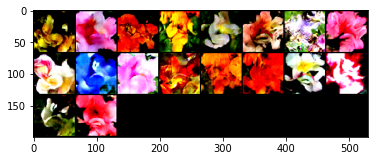

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 72, lossD:0.6431313329240651, lossG:6.379951537234112,lossG_fake:2.8872463436960016, lossG_real:3.4927051784922774 


evaluate:108.89958953857422,kid_mean:0.06269164383411407, kid_std:0.03673693537712097,kid_:(tensor(0.0627), tensor(0.0367))


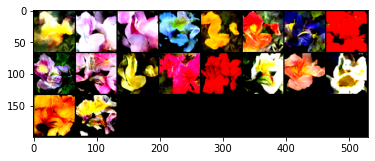

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 73, lossD:0.7143684114935329, lossG:6.458599761851783,lossG_fake:2.874424714486576, lossG_real:3.5841750716700136 


evaluate:108.76285552978516,kid_mean:0.0677780732512474, kid_std:0.040139339864254,kid_:(tensor(0.0678), tensor(0.0401))


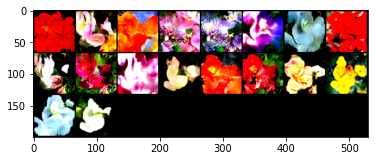

100%|██████████| 103/103 [00:59<00:00,  1.74it/s]


epoch: 74, lossD:0.6718065135397957, lossG:6.480719719118285,lossG_fake:2.874003943887729, lossG_real:3.6067157682863256 


evaluate:108.83606719970703,kid_mean:0.06766758859157562, kid_std:0.03655046224594116,kid_:(tensor(0.0677), tensor(0.0366))


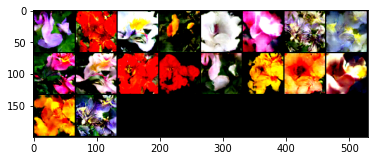

In [ ]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []
relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0
    #for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))
        

        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()
        
        #train generator
        
        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake    


        lossG.backward()
        optimizerG.step()
        
        # save loss
        
        running_lossD += lossD.item()
        running_lossG += lossG.item()
        
        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()


        
    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)

    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()

    
  
    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

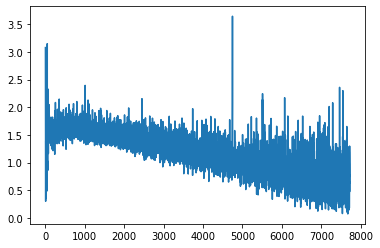

In [ ]:
plt.plot(raw_lossesD)

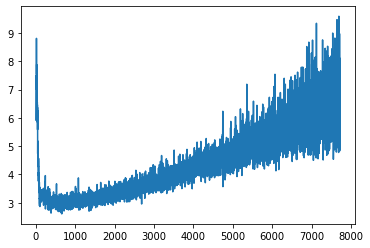

In [ ]:
plt.plot(raw_lossesG)

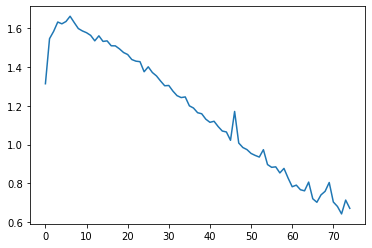

In [ ]:
plt.plot(lossesD)

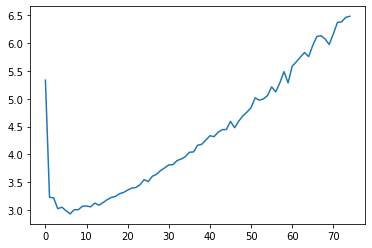

In [ ]:
plt.plot(lossesG)

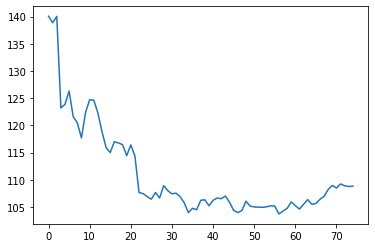

In [ ]:
plt.plot(fid_)

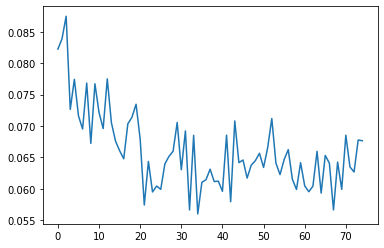

In [ ]:
plt.plot(kid_mean_)

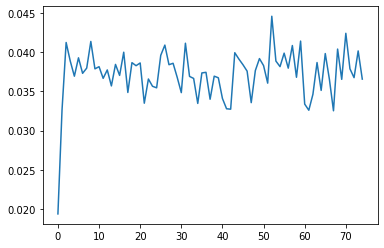

In [ ]:
plt.plot(kid_std_)

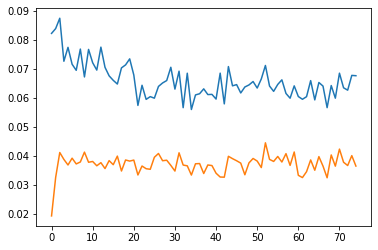

In [ ]:
plt.plot(kid_score)

In [ ]:

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
fid.compute()

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
kid.compute()

(tensor(0.0638), tensor(0.0389))